In [ ]:
import rasterio

In [2]:
dataset = rasterio.open('example.tif')

In [3]:
dataset.name

'example.tif'

In [4]:
dataset.mode

'r'

In [5]:
dataset.closed

False

In [6]:
dataset.count

2

In [7]:
dataset.width

29819

In [8]:
dataset.height

21992

In [9]:
{i: dtype for i, dtype in zip(dataset.indexes, dataset.dtypes)}

{1: 'float32', 2: 'float32'}

In [10]:
dataset.bounds

BoundingBox(left=154580.59591206638, bottom=473506.1972031946, right=452770.5959120664, top=693426.1972031946)

In [11]:
dataset.transform

Affine(10.0, 0.0, 154580.59591206638,
       0.0, -10.0, 693426.1972031946)

Spatial position of the upper left corner.

In [12]:
dataset.transform * (0, 0)

(154580.59591206638, 693426.1972031946)

Position of the lower right corner

In [13]:
dataset.transform * (dataset.width, dataset.height)

(452770.5959120664, 473506.1972031946)

But what do these numbers mean? 4028985 meters from where? These coordinate values are relative to the origin of the dataset’s coordinate reference system (CRS).

In [14]:
dataset.crs

CRS.from_dict(init='epsg:27700')

### Reading raster data

Data from a raster band can be accessed by the band’s index number. Following the GDAL convention, bands are indexed from 1.

In [15]:
dataset.indexes

(1, 2)

In [16]:
from rasterio import windows
# top left (309383,578658), bottom right (331817,562961)

center_height = dataset.height // 2
center_width = dataset.width // 2
window = rasterio.windows.Window(8000,4500,1000,1000)
#window = rasterio.windows.Window(center_height, center_width, center_height + 512, center_width + 256)

window_band1 = dataset.read(1, window=window)

center_height, center_width

(10996, 14909)

The read() method returns a Numpy N-D array.

In [17]:
window_band2 = dataset.read(2, window=window)

In [18]:
window_band1

array([[-10.0057955,  -9.914148 ,  -9.782564 , ..., -11.648204 ,
        -10.20707  ,  -9.353138 ],
       [ -9.967886 , -11.37946  , -11.223095 , ..., -12.187187 ,
        -10.702338 ,  -9.386102 ],
       [-10.779752 , -12.492971 , -12.379423 , ..., -12.572582 ,
        -11.646425 , -10.112815 ],
       ...,
       [ -9.941857 , -10.222252 ,  -9.978912 , ...,  -4.20261  ,
         -4.7136097,  -8.611703 ],
       [ -9.973844 , -10.606692 , -10.010782 , ...,  -6.1382236,
         -6.2736454,  -9.422823 ],
       [ -9.932967 , -10.6442585,  -9.478745 , ...,  -8.585444 ,
         -9.175529 , -10.262896 ]], dtype=float32)

In [19]:
window_band2

array([[-16.857645, -17.179258, -16.929314, ..., -19.400192, -19.396696,
        -18.924877],
       [-16.423817, -16.693312, -16.607874, ..., -19.801975, -18.98138 ,
        -17.572548],
       [-15.97689 , -16.26646 , -16.298498, ..., -19.544617, -18.616032,
        -17.031904],
       ...,
       [-16.639439, -17.306795, -17.390787, ..., -13.658561, -13.271535,
        -13.157079],
       [-16.405308, -17.323841, -17.356457, ..., -14.057482, -13.412106,
        -13.075417],
       [-16.510143, -16.890724, -16.612814, ..., -15.441355, -14.494944,
        -13.816211]], dtype=float32)

### Spatial indexing

Datasets have an index() method for getting the array indices corresponding to points in georeferenced space. To get the value for the pixel 100 kilometers east and 50 kilometers south of the dataset’s upper left corner, do the following.

In [20]:
x, y = (dataset.bounds.left + center_width, dataset.bounds.top - center_height)

In [21]:
row, col = dataset.index(x, y)
row, col

(1099, 1490)

In [22]:
window_band2[row, col]

IndexError: index 1099 is out of bounds for axis 0 with size 1000

To get the spatial coordinates of a pixel, use the dataset’s xy() method. The coordinates of the center of the image can be computed like this.

In [23]:
dataset.xy(dataset.height // 2, dataset.width // 2)

(303675.5959120664, 583461.1972031946)

### Creating data

Reading data is only half the story. Using Rasterio dataset objects, arrays of values can be written to a raster data file and thus shared with other GIS applications such as QGIS.

In [24]:
import matplotlib.pyplot as plt
import numpy as np

band1 = np.array(window_band1)
band1_values = band1.flatten()

In [25]:
np.nanmin(band1_values), np.nanmax(band1_values)

(-22.894981, 16.503237)

In [26]:
hist, bin_edges = np.histogram(band1, range=(np.nanmin(band1_values),np.nanmax(band1_values)), density=True)
hist, bin_edges

(array([4.67026197e-05, 3.17197086e-03, 1.32795600e-01, 1.08208701e-01,
        7.94096826e-03, 1.17594151e-03, 3.44939458e-04, 1.09649629e-04,
        1.90363939e-05, 5.07637171e-06]),
 array([-22.89498138, -18.95515957, -15.01533775, -11.07551594,
         -7.13569412,  -3.19587231,   0.74394951,   4.68377132,
          8.62359314,  12.56341496,  16.50323677]))

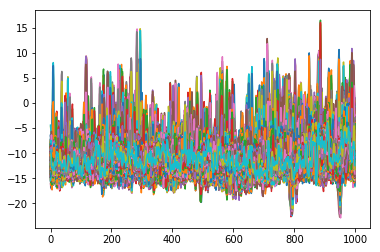

In [27]:
import matplotlib.pyplot as plt

plt.plot(window_band1)
plt.show()

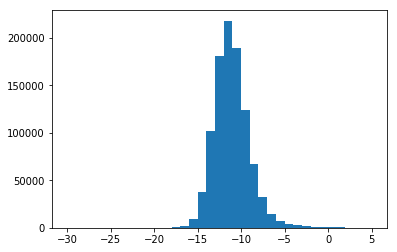

In [28]:
plt.hist(band1_values, bins=[-30,-29,-28,-27,-26,-25,-24,-23,-22,-21,-20,-19,-18,-17,-16,-15,-14,-13,-12,-11,-10, -9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5], range=(np.nanmin(band1_values),np.nanmax(band1_values)))
plt.show()

In [29]:
def calc_ndvi(nir,red):
    '''Calculate NDVI from integer arrays'''
    nir = nir.astype('f4')
    red = red.astype('f4')
    ndvi = (nir - red) / (nir + red)
    return ndvi

Text(0,0.5,'Row #')

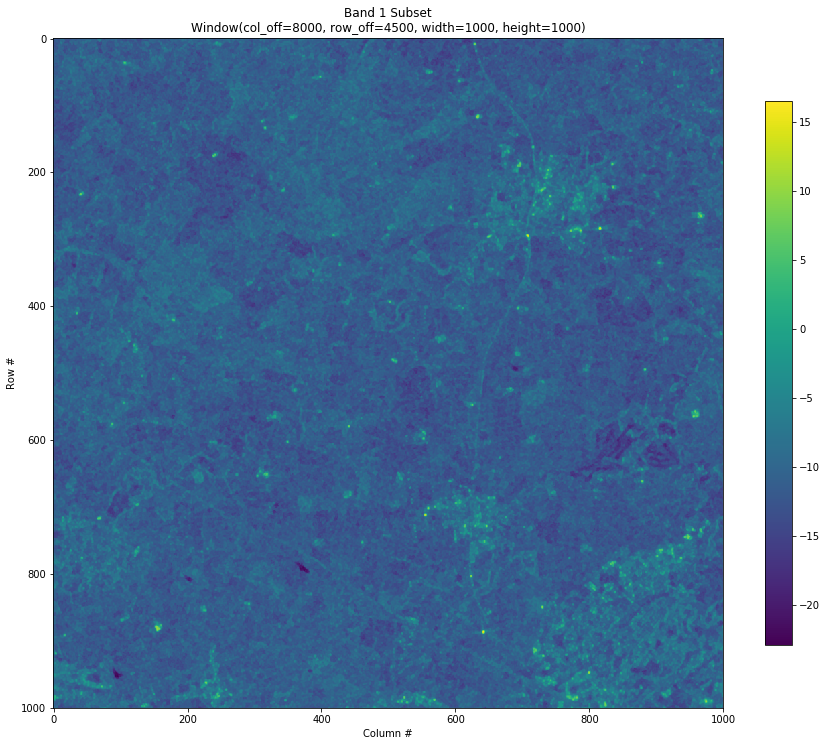

In [47]:
plt.figure(figsize=(15,20))
plt.imshow(window_band1)
plt.colorbar(shrink=0.5, cmap='gist_earth')
plt.title(f'Band 1 Subset\n{window}')
plt.xlabel('Column #')
plt.ylabel('Row #')

In [44]:
# Function to normalize the grid values
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

# Normalize the bands
window_band1_norm = normalize(window_band1)
window_band2_norm = normalize(window_band2)

print("Normalized bands")
print(window_band1_norm.min(), '-', window_band1_norm.max(), 'mean:', window_band1_norm.mean())
print(window_band2_norm.min(), '-', window_band2_norm.max(), 'mean:', window_band2_norm.mean())

Normalized bands
0.0 - 1.0 mean: 0.3006666
0.0 - 1.0 mean: 0.3089647


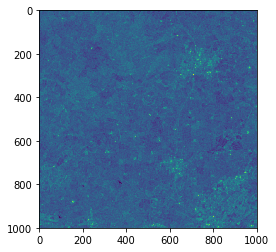

In [51]:
# Create RGB natural color composite
rgb = np.dstack((window_band1_norm, window_band2_norm))

# Let's see how our color composite looks like
plt.imshow(window_band1_norm)

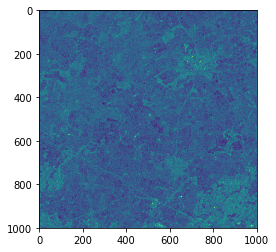

In [50]:
plt.imshow(window_band2_norm)

TypeError: Invalid dimensions for image data

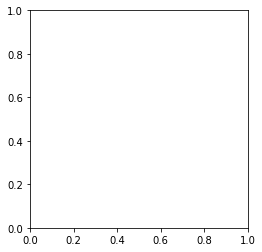

In [56]:
from rasterio.plot import show
import os
%matplotlib inline

nrg = np.dstack((window_band1_norm, window_band2_norm))

plt.imshow(nrg)